## Ruchdart Method - Air

Import modules

In [1]:
import pandas as pd
import math
import numpy as np 
import os
from scipy import stats
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

Change file path to root of the project in order to access the data

In [2]:
current_directory = os.getcwd() 
project_directory=os.path.dirname(os.path.dirname(current_directory))

Initialise function for gamma and the error on gamma

In [3]:
#Equation given in ref. 2 of script for ratio of heat capacities
#m = Mass of Ball, V = Volume of Tube, A = Cross-Sectional Area of the Tube, t = Time Period
def ratio(m,V,A,P,t):
    gamma=(4*(math.pi ** 2)*(m*(10**(-3)))*V)/(P * ((t*0.004)**2)*(A**2))
    return gamma

def gammaError(gamma,EoM,EoV,EoA,EoP,EoT):
    
    #Error Contributions from partial derivatives
    CoM=gamma/m
    CoV=gamma/V
    CoA=-(2*gamma)/A
    CoP=-(gamma)/P
    CoT=-(2*gamma)/(np.mean(peak_pos_diff)*0.004)
    
    #Breaking up the calculation
    err_mass=(CoM**2)*(EoM**2)
    err_vol=(CoV**2)*(EoV**2)
    err_area=(CoA**2)*(EoA**2)
    err_pressure=(CoP**2)*(EoP**2)
    err_time=(CoT**2)*(EoT**2)
    
    #Cobmine contributions
    gamma_error=(err_mass+err_vol+err_area+err_pressure+err_time)**(1/2)
    
    return gamma_error

Set the fixed variables, these are from `data/raw/Ball_Details.txt` and `data/raw/Air/Ruchdart_Method/Extra_Details.txt`

Also intialise some arrays to store the found values outside the main loop

In [4]:
#Ball Masses
m=[25.3352,35.8999,13.4999]

#Variables for Air
P = 994.4 *(10**2)
V=12.85 *(10**(-3))
d=20 *(10 **(-3))
A=math.pi*((d/2)**2)

#Errors on values
EoM=10**(-7)
EoV=10**(-4)
EoA=(math.pi)*(10**(-6))
EoP=50

#Intialise arrays for found values
found_gammas=[]
error_found_gammas=[]

This is the main loop that does the hard work:

1. Get pressure data from .txt 
2. Remove points before oscillations start
3. Find the peaks of the oscillations using **[`scipyscipy.signal.find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)**
4. Only keep peaks above the noise floor 
5. Find the average time periods between peaks
6. Find gamma and the assosciated error
7. Plot results

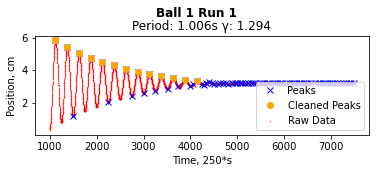

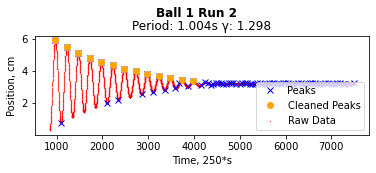

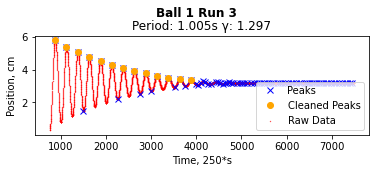

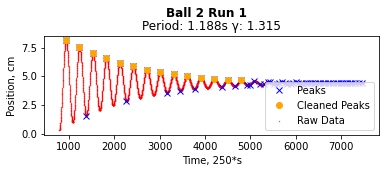

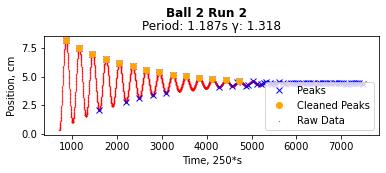

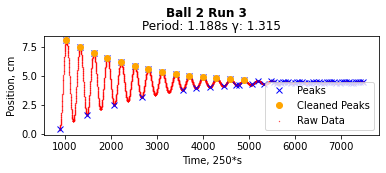

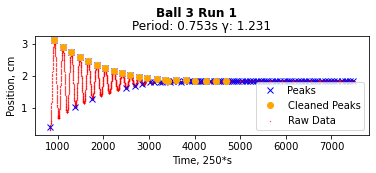

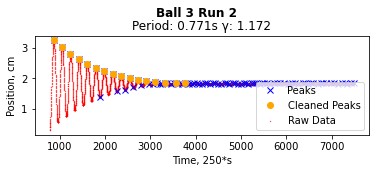

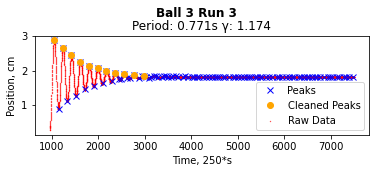

,Ball Number,Run Number,Gamma,Error on Gamma
0,1,1,1.293988,0.030629
1,1,2,1.298287,0.028831
2,1,3,1.297425,0.028593
3,2,1,1.315489,0.028814
4,2,2,1.317537,0.029914
5,2,3,1.315489,0.029686
6,3,1,1.231327,0.123227
7,3,2,1.172461,0.061914
8,3,3,1.174490,0.061208


Mean Gamma: 1.2684991696965022
Error on Mean Gamma: 0.018578518415497573


In [5]:
for ballnumber in range(1,4):                  
    for runnumber in range(1,4):          
        
        #Get data from text file, arguments are just based on formatting of .txt
        df = pd.read_csv(str(project_directory)+'/data/raw/Air/Ruchardt_Method/Ball_'+str(ballnumber)+'_Run_'+str(runnumber)+'.txt', delim_whitespace=True, skiprows=6, error_bad_lines=False )
        
        #Put this data into a list as strings, getting rid of the formatting stuff that isn't numbers
        t_list_str = list(df.iloc[:,2].astype(str).str.slice(start=0,stop=6,step=1))

        #Change list entries of t to floats from strings 
        t_list=[float(u) for u in t_list_str]

        #Get rid of constant times at start
        b=0
        while b<len(t_list):
            if (t_list[b+1]-t_list[b]) < 0.02:
                t_list[b-1]=np.nan    #nan not zero as don't want to plot them
                b+=1
            else:
                b+=len(t_list)
       
        #Initalise array here so they clear every iteration
        orig = np.zeros((2,7500))
        
        #Create 2-D array with orginal values
        orig[0,:]=t_list
        orig[1,:]=range(len(t_list))
        
        #Find Peaks with scipy, min dist between peaks is 45 points
        peaks, _ = find_peaks(orig[0,:], distance=45) 

        #Create new array with only the peaks (no minima)
        #and only the peaks in the larger oscialltion (LHS) part above noise floor
        clean_peaks = np.zeros((2,7500))
        friction_peaks=np.zeros((2,7500))
        clean_peaks[1,:] = range(len(t_list))  #x-values
        clean_peaks[clean_peaks==0] = np.nan
        for n in peaks:
            if ballnumber==1:
                if orig[0,n]>3.3:  #This is specific to each ball, is the value where it reaches equilbirium(& gets noisy)
                    clean_peaks[0,n]=orig[0,n]
            if ballnumber==2:
                if orig[0,n]>4.6:  
                    clean_peaks[0,n]=orig[0,n]
            if ballnumber==3:
                if orig[0,n]>1.85:
                    clean_peaks[0,n]=orig[0,n]
        
        
        #Find the average time periods
        peak_pos=[]
        for n in range(7500):
            if clean_peaks[0,n]>0:
                peak_pos.append(clean_peaks[1,n])
                
        peak_pos_diff=np.diff(peak_pos)                                  #Find difference in positions of peaks(time-period)
        found_ratio = ratio(m[ballnumber-1],V,A,P,np.mean(peak_pos_diff))         #Using variable here as I will need to use in errors
        found_gammas.append(ratio(m[ballnumber-1],V,A,P,np.mean(peak_pos_diff)))  #Add all values to list to find mean for gas overall
        
        #Find errors
        time_periods=[0.004*i for i in peak_pos_diff]           #Change into seconds
        EoT=stats.sem(time_periods, ddof=4)                     #Find standard error on mean
        error_found_gammas.append(gammaError(found_ratio,EoM,EoV,EoA,EoP,EoT)[0])
        
        
        #Plot time periods
        fig = plt.figure()
        ax0 = fig.add_subplot(211)
        fig.suptitle('Ball '+str(ballnumber)+" Run "+str(runnumber), fontsize=12, fontweight='bold')
        ax0.set_title("Period: "+str(round(np.mean(peak_pos_diff)*0.004,3))+"s "+"γ: "+str(round(ratio(m[ballnumber-1],V,A,P,np.mean(peak_pos_diff)),3)))
        ax0.scatter(range(len(t_list)),t_list, s=0.1, color='r', label="Raw Data")
        ax0.plot(peaks,orig[0,peaks], "x", label="Peaks", color="b")
        ax0.plot(clean_peaks[1,:],clean_peaks[0,:], "o", label="Cleaned Peaks", color='orange')
        plt.xlabel("Time, 250*s") 
        plt.ylabel("Position, cm")
        plt.legend(loc='lower right')
        plt.show()
        

#Put values into dict to display with pandas
dict={'Ball Number': [1,1,1,2,2,2,3,3,3], 'Run Number':[1,2,3,1,2,3,1,2,3], 'Gamma': found_gammas, 'Error on Gamma': error_found_gammas}
display(pd.DataFrame(dict))

#Combine errors
sumerravg=[((i)**2)/81 for i in error_found_gammas]

#Print final results 
print("Mean Gamma: "+str(np.mean(found_gammas))) 
print("Error on Mean Gamma: "+str((np.sum(sumerravg))**(1/2)))


If you get any errors here, re-run all cells in descending order :)